# **Finding Lane Lines on the Road**
by Graham Arthur Mackenzie

The following notebook explains my process for developing a pipeline for identifying lane lines on the road, first for still images, and then for video streams.

Naturally, we begin by importing necessary / useful packages.

In [1]:
# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

Next we read in our image and convert it to grayscale because, as the professor said, "lane lines are not always the same color, and even lines of the same color under different lighting conditions (day, night, etc) may fail to be detected by our simple color selection."

(Note: I will be printing the output of each step into our notebook here, but such a step is obviously not necessary to the process and will be removed from the final pipeline.)

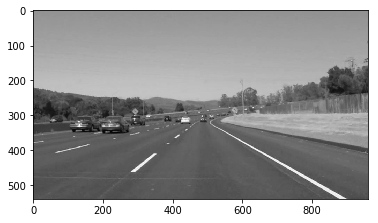

In [2]:
# Read in the image and convert to grayscale
image = mpimg.imread('test_images/solidWhiteCurve.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray')

Next, although our Canny edge detection algorithm (which we are about to use in a minute) includes a Gaussian noise reduction step, we will do more of the same before applying it because that "internal" blurring can't be tuned. I am using the professor's preferred kernel size of 5 here.

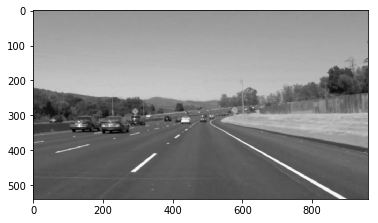

In [3]:
# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
plt.imshow(blur_gray, cmap='gray')

Next, we apply a Canny edge detection algorithm to find the edges of distinct shapes in the picture. Seeing as the range of possible values is between 0 and 254, and John Canny himself suggested a low to high threshold ratio of 1:2 or 1:3, the professor has gone with values of 50 and 150, which parameters we retain here.

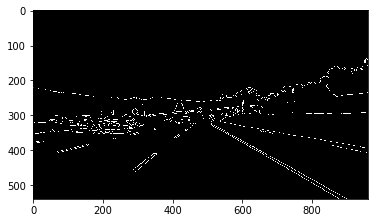

In [4]:
# Define our parameters for Canny and apply
low_threshold = 50
high_threshold = 150
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.imshow(edges, cmap='gray')

As seen above, the distinct edges are now indicated by a series of dots. Before we attempt to detect the lines within these dots, we will apply a mask to the image so as to filter out the overwhelming majority of it, as we are only interested in detecting the lines in the lane directly in front of our car.

In [5]:
# Next we'll create a masked edges image using cv2.fillPoly()
mask = np.zeros_like(edges)
ignore_mask_color = 255

For the polygon defined below for our mask I began with the professor's suggested dimensions of (0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0]) and then tweaked them to make the upper edge 35 pixels lower in the image space. This allowed me to exclude a lot of noisy lines that were being generated by the cars in front of ours.

In [6]:
# We are defining a four sided polygon to mask
imshape = image.shape
vertices = np.array([[(0,imshape[0]), (450, 325), (490, 325), (imshape[1],imshape[0])]], dtype=np.int32)
cv2.fillPoly(mask, vertices, ignore_mask_color)
masked_edges = cv2.bitwise_and(edges, mask)

Next we apply a Hough transformation which detects straight lines amidst all the dots left behind by our Canny edge detector. As before, I begin with the parameters (rho, theta, threshold, min_line_length, max_line_gap) suggested by the professor. In this case, they worked for me, so I have left them as is.

In [7]:
# Define the Hough transform parameters
rho = 2
theta = np.pi/180
threshold = 15
min_line_length = 40
max_line_gap = 20

# Run Hough on edge detected image
lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

As a final step, we take the lines generated by the Hough transform and draw them onto a blank image the same size as our original.

Note that in the logic below, I have sorted the lines into two batches based on the sign of their slope. This is unnecessary for our purposes here, but will be useful when we transition from analysing still images to video clips.

This same logic step excludes any slopes that are (respectively) greater than -0.5 or less than 0.5. This is done as a means of filtering out any lines that are significantly different from the range expected for our lane lines (that is, closer to horizontal) as those will be noise in this case.

In [8]:
# Make a blank the same size as our image to draw on
line_image = np.copy(image)*0 #creating a blank to draw lines on

#Iterate over the output "lines" and draw lines on the blank image
for line in lines:
    for x1,y1,x2,y2 in line:
        slope = ((y2 - y1) / (x2 - x1))
        if slope < -0.5:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,127,127),10)
        elif slope > 0.5:
            cv2.line(line_image,(x1,y1),(x2,y2),(0,127,127),10)

Lastly, we combine the original image and the blank with lines generated onto it into one merged image. This allows us to produce a version of the raw footage annotated with lane lines.

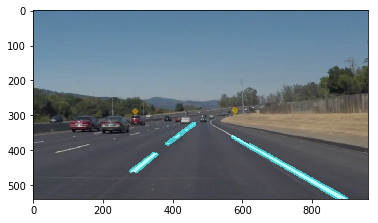

In [9]:
# Draw the lines on the original image
lines_original = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.imshow(lines_original)

The above pipeline is repeated below in a single function in order to be able to be applied to a video stream.

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    
    # We are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (450, 325), (490, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0
    
    # Hough Line approach
    
    # Iterate over the output "lines" and draw lines on the blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            if slope < -0.5:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,127,127),10)
            elif slope > 0.5:
                cv2.line(line_image,(x1,y1),(x2,y2),(0,127,127),10)

    # Draw the lines on the original image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0) 

    return result

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:11<00:00, 63.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 8.59 s, sys: 3.3 s, total: 11.9 s
Wall time: 12 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

The results above are equivalent to raw-lines-example.mp4, thereby satisfying the first two criteria of this project.

Next we tweak our pipeline in order to "filter / average / extrapolate" the detected line segments in order "to map out the full extent of the left and right lane boundaries", per the project rubric.

Having already fine-tuned the parameters of the grayscale, Gaussian smoothing, Canny edge detector, mask shape, and Hough transform, those can all be left alone. All of the changes come in the line drawing part of the pipeline, explained inline below with comments.

In [14]:
    # Averaged approach
    
    # We need arrays within which to hold all of the slopes
    # of all of the lines generated, so that we can find
    # their average value, one for each side of the lane
    left_slopes = []
    right_slopes = []
    
    # Next we need a single point from each side of the lane
    # that we can use to extrapolate to the top and bottom
    # of the lane. For the sake of consistency / smoothness
    # we want to choose the point that is lowest in the image
    # space which, because the origin is in the upper left,
    # translates (on the left side) to the point with the minimum
    # x and maximum y value and (on the right side) max x
    # and y value. We initialize these variables accordingly,
    # so that the min and maxes can be found below
    left_min_x1 = 1000
    left_max_y1 = 0
    right_max_x2 = 0
    right_max_y2 = 0
    
    # We create two global variables to hold onto values
    # (used below) between iterations in case the algorithm
    # isn't able to detect any lines in any particular still image
    global left_x_1
    global right_x_1
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            if slope < -0.5:
                # In addition to depending on the sign of the slope
                # to filter out the left and right side of the lane,
                # and the size of the slope to filter out "noisy" lines,
                # we use the below parameter (and its analogue in the
                # elif statement) to make sure that we're only dealing
                # with lines on one side of the image space or the other
                # (hence the cut off of 480 pixels, which happens to be
                # the midpoint of this image.) This was necessary because
                # our alg was picking up lines with the "correct" slope
                # that were on the "incorrect" side of the screen
                if x1 < 480:
                    # Here is where we collect the slope of each line
                    # in its respective array to be averaged below
                    left_slopes.append(slope)
                    # This step (and the analogue in the elif statement)
                    # identifies the point with the lowest x and highest y
                    # to be used in our extrapolation
                    if x1 < left_min_x1:
                        left_min_x1 = x1
                    if y1 > left_max_y1:
                        left_max_y1 = y1
            elif slope > 0.5:
                if x2 > 480:
                    right_slopes.append(slope)
                    if x2 > right_max_x2:
                        right_max_x2 = x2
                    if y2 > right_max_y2:
                        right_max_y2 = y2

    # Here's where we average our slopes
    left_slope = np.mean(left_slopes)
    right_slope = np.mean(right_slopes)

    # This if statement (and its analogue below) serves to make sure that
    # at least one line was discovered in this video frame. If one wasn't,
    # then left_min_x1 would be left alone to  be the value set at the 
    # beginning of this function (ie, 1000)
    if left_min_x1 != 1000:
        # In order to extrapolate from our point chosen above down to the lower
        # edge of our image space (which is at y = 540) we subtract 540 from
        # the y coordinate of our point, and then divide that by the averaged
        # slope, which gives us the distance (in x) from our point to the
        # extrapolated point
        left_run_1 = int((left_max_y1 - 540) / left_slope)
        # We then subtract this distance in x from the x coordinate of our chosen
        # point, which gives us, effectively, the x-intercept of our extrapolated line.
        # The y coordinate of our extrapolation, as mentioned, is already known to be 540.
        # Also as mentioned, if our alg happened to not detect any lines in this frame
        # it will remain the same as the last frame (as it is unlikely to have changed that
        # much in 1/30th of a second) which is why left_x_1 (and right_x_1, used below) were
        # set to be global variables
        left_x_1 = left_min_x1 - left_run_1

    # We draw the left lane line using the extrapolated lower point, and an upper
    # point of (455, 325) -- and (510, 325) in the case of the right side of the lane. 
    # These values were found by trial and error and are the kluge-iest
    # part of our algorithm. Initially, our algorithm extrapolated an upper point in 
    # the same way that it did a lower point and connected the two, but that caused the lines drawn - while
    # accurate - to be extremely jittery. Studying the example provided of P1_example.mp4,
    # I eventually realized that the jitteriness was largely caused by the variability of the
    # upper point, while the variability of the lower point was much less noticeable. 
    # I also realized that - even for lanes that had some curve in them - they remained
    # straight for a considerable distance beforehand. Thus, for the sake of completing
    # this project, I decided to just select two upper points that worked for the purposes
    # of the videos in this project. Needless to say, it has produced satisfactory results
    # for the task at hand, but a very un-robust algorithm which will need to be greatly
    # improved upon in the future (as it turns out, I ended up improving it for the challenge video.)
    cv2.line(line_image,(left_x_1, 540),(455, 325),(0,127,127),10)
        
    if right_max_x2 != 0:
        right_run_1 = int((540 - right_max_y2) / right_slope)
        right_x_1 = right_max_x2 + right_run_1

    cv2.line(line_image,(right_x_1, 540),(510, 325),(0,127,127),10)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ..., 
       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ..., 
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

We reiterate the pipeline below with the extrapolation code, and the other test video to follow.

In [15]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    
    # We are defining a four sided polygon to mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]), (450, 325), (490, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_length = 40
    max_line_gap = 20

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0
                
    # Averaged approach
    left_slopes = []
    right_slopes = []
    left_min_x1 = 1000
    left_max_y1 = 0
    right_max_x2 = 0
    right_max_y2 = 0
    global left_x_1
    global right_x_1
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            if slope < -0.5:
                if x1 < 480:                    
                    left_slopes.append(slope)
                    if x1 < left_min_x1:
                        left_min_x1 = x1
                    if y1 > left_max_y1:
                        left_max_y1 = y1
            elif slope > 0.5:
                if x2 > 480:
                    right_slopes.append(slope)
                    if x2 > right_max_x2:
                        right_max_x2 = x2
                    if y2 > right_max_y2:
                        right_max_y2 = y2

    left_slope = np.mean(left_slopes)
    right_slope = np.mean(right_slopes)

    if left_min_x1 != 1000:
        left_run_1 = int((left_max_y1 - 540) / left_slope)
        left_x_1 = left_min_x1 - left_run_1

    cv2.line(line_image,(left_x_1, 540),(455, 325),(0,127,127),10)
        
    if right_max_x2 != 0:
        right_run_1 = int((540 - right_max_y2) / right_slope)
        right_x_1 = right_max_x2 + right_run_1

    cv2.line(line_image,(right_x_1, 540),(510, 325),(0,127,127),10)

    # Draw the lines on the original image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0) 

    return result

In [16]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 55.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.8 s, sys: 1.16 s, total: 3.96 s
Wall time: 4.44 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

The results above are equivalent to P1_example.mp4, thereby satisfying the third criterion of this project.

# **Reflection**

- The current pipeline was described in detail above.
- Potential shortcomings:
    - As mentioned, the fact that the upper points on our extrapolated lines are both hand-coded and arbitrarily chosen, rather than dynamically generated based on real data, is a major drawback
    - Many of the dimensions of the input image and mask polygon needed to be hand coded, which introduces more algorithm fragility
    - The algorithm presumes that the car is driving on streets that remain more or less straight directly in front of it. While this sufficed for this project, and will probably hold true for 99% of all roads, it is an unacceptable limitation generally
- Suggested possible improvements:
    - I wanted to finalize my own solution before looking at my peers'. Having done that, I have now seen that some of them averaged not only the slope but the x and y coordinates of all lines before extrapolating. This is probably preferable to doing so based on a single point and the average slope, and likely addresses the first and third shortcoming mentioned above
    - Ideally, the algorithm would somehow be able to account for camera inputs of differing dimensions (not only because different roads have different dimensions, but because the same road looks different from a different camera angle), specifically in regards to the mask, where so much depends on hand-crafting a solution after looking at it with human eyes first
    - Although the output of this algorithm will more likely be fed into a later part of the larger system, if it were to be for human consumption we would presumably want to provide the user with some control over line size / style / color, etc. In such case, it might be nice to provide a UX for this purpose
    
The above reflection satisfies the fourth criterion of this project.

# **Challenge Round!**

So, even though the pipeline I developed successfully satisfied all of the project criteria, it produced a barely satisfactory (to me) result on the challenge video. Therefore, I went back to the drawing board by looking at what my classmates (primarily Esmat Nabil and Jendrik Jördening) had done (something I hadn't allowed myself to do while developing my initial pipeline) and came up with the following changes / improvements:

- Much of the challenge of the challenge video comes in the section when the pavement goes from dark black to light gray. This, naturally, has the effect of making the lane lines "invisible" because there is no longer enough contrast between pavement and line for them to stand out. To account for this, I messed around with the Canny thresholds (both by lowering/raising the low_threshold and changing the threshold ratio from 1:3 to 1:2) but most every change caused no lines to be seen. Thus, I ended up leaving it at 50:150. A potential improvement might be to develop a dynamic Canny alg that can adjust based on the tone of the pavement.
- No matter which parameters I employed for the Canny detector or the Hough transform, the section of the pavement /between/ the lanes always introduced noise because of the line in the transition from dark to light to dark pavement, and the little tire skid marks throughout. To get around this, I replaced the single quadrilateral mask with two parallelograms - one for each lane. Though some artifacts still crept in, this greatly improved the situation.
- I also updated some of the hand-coded bits of the mask, to account for the different image size compared to the first two videos, and to remove the bit of car hood sticking into the bottom of the frame.
- As with most tricky problems, this one was about balancing competing priorities. The parameters of the Hough transform were things I needed to tweak and test over and over again throughout this process. In all of the test videos in this project, one of our lane lines was solid and the other was dashed. In practice, this meant that, in order to make the Hough lines short enough to catch the dashed line, we necessarily opened ourselves up to picking up little artifacts around the solid line / elsewhere. This was especially true in the challenge video. After much experimentation, I settled on the following params: rho = 2, theta = np.pi/180, threshold = 5, min_line_length = 20, max_line_gap = 10.
- I tightened up the logic of the slope allowances to give them a maximum as well as a (more precise) minimum as a means of filtering out more noise.
- My main change in mathematical approach was to move from extrapolating from a single point to fitting a regression line to a collection of all points in each frame.
- To account for the fact that many of the video frames have little to no lines on one side or the other or both, oftentimes for multiple frames in a row, I had to set some global variables so that the pipeline could just redraw the previous known line during those dry spells (as things were unlikely to change greatly in a fraction of a second.)
- In order to smooth out the jitters of my lines, and as a means of lessening the impact of the stray noisy line that I hadn't been able to filter out by the above means, I also added four global arrays to hold the x values of my four extrapolated points (because the y values are still chosen / determined ahead of time) over multiple frames so that they could be averaged before fitting my lines.
- The nature of global variables in Python (or, at least, in Jupyter notebooks) is such that I had to add a cell before my pipeline where I reset the above global arrays to be blank, otherwise they would retain their values from each iteration of the process, thereby flattening out the significance of any individual run.

Find my improved challenge video pipeline below.

In [18]:
l_exes_1 = []
l_exes_2 = []
r_exes_1 = []
r_exes_2 = []

In [19]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Next we'll create a masked edges image using cv2.fillPoly()
    mask = np.zeros_like(edges)
    ignore_mask_color = 255
    
    # We are defining a four sided polygon to mask
    imshape = image.shape
    vertices1 = np.array([[(240,700), (620, 440), (660, 440), (260,700)]], dtype=np.int32)
    vertices2 = np.array([[(1120,700), (620, 440), (660, 440), (1140,700)]], dtype=np.int32)
    shapes = [vertices1, vertices2]
    cv2.fillPoly(mask, shapes, ignore_mask_color)
    masked_edges = cv2.bitwise_and(edges, mask)
    
    # Define the Hough transform parameters
    rho = 2
    theta = np.pi/180
    threshold = 5
    min_line_length = 20
    max_line_gap = 10

    # Run Hough on edge detected image
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)
    
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0

    # New averaged approach
    left_slopes = []
    right_slopes = []
    
    raw_l_exes = []
    raw_l_whys = []
    raw_r_exes = []
    raw_r_whys = []
    
    global lx1
    global ly1
    global lx2
    global ly2
    global rx1
    global ry1
    global rx2
    global ry2
    
    global l_exes_1
    global l_exes_2
    global r_exes_1
    global r_exes_2
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2 - y1) / (x2 - x1))
            if slope < -0.6:
                if slope > -0.8:
                    if x2 < 690:                    
                        left_slopes.append(slope)
                        raw_l_exes.append(x1)
                        raw_l_exes.append(x2)
                        raw_l_whys.append(y1)
                        raw_l_whys.append(y2)
            elif slope > 0.6:
                if slope < 0.8:
                    if x1 > 690:
                        right_slopes.append(slope)
                        raw_r_exes.append(x1)
                        raw_r_exes.append(x2)
                        raw_r_whys.append(y1)
                        raw_r_whys.append(y2)

    if raw_l_exes:
        print(l_exes_1)
        l_coefs = np.polyfit(raw_l_exes, raw_l_whys, 1)
        ly1 = 1280
        foo = int((ly1 - l_coefs[1]) / l_coefs[0])
        l_exes_1.append(foo)
        lx1 = int(np.mean(l_exes_1[-5:]))
        ly2 = 450
        bar = int((ly2 - l_coefs[1]) / l_coefs[0])
        l_exes_2.append(bar)
        lx2 = int(np.mean(l_exes_2[-8:]))
        
    cv2.line(line_image,(lx1, ly1), (lx2, ly2),(0,127,127),10)
    
    if raw_r_exes:
        print(r_exes_1)
        r_coefs = np.polyfit(raw_r_exes, raw_r_whys, 1)
        ry1 = 1280
        boo = int((ry1 - r_coefs[1]) / r_coefs[0])
        r_exes_1.append(boo)
        rx1 = int(np.mean(r_exes_1[-5:]))
        ry2 = 450
        far = int((ry2 - r_coefs[1]) / r_coefs[0])
        r_exes_2.append(far)
        rx2 = int(np.mean(r_exes_2[-8:]))
        
    cv2.line(line_image,(rx1, ry1), (rx2, ry2),(0,127,127),10)

    # Draw the lines on the original image
    result = cv2.addWeighted(image, 0.8, line_image, 1, 0) 

    return result

In [20]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[]
[]
[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

[-561]
[2075]
[-561, -561]


  1%|          | 2/251 [00:00<00:16, 15.56it/s]

[-561, -561, -568]
[-561, -561, -568, -534]
[-561, -561, -568, -534, -551]
[-561, -561, -568, -534, -551, -551]


  4%|▍         | 11/251 [00:00<00:10, 22.75it/s]

[-561, -561, -568, -534, -551, -551, -597]
[-561, -561, -568, -534, -551, -551, -597, -602]
[-561, -561, -568, -534, -551, -551, -597, -602, -603]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603]
[2075, 2075]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585]
[2075, 2075, 2047]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599]
[2075, 2075, 2047, 2036]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590]
[2075, 2075, 2047, 2036, 2045]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574]


  8%|▊         | 20/251 [00:00<00:07, 29.30it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -

 10%|▉         | 25/251 [00:00<00:07, 31.73it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569]
[2075, 2075, 2047, 2036, 2045, 2049, 2070]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565]


 12%|█▏        | 29/251 [00:00<00:06, 31.94it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572]


 13%|█▎        | 33/251 [00:00<00:06, 33.20it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565

 15%|█▍        | 37/251 [00:01<00:06, 33.93it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034]


 16%|█▋        | 41/251 [00:01<00:05, 35.41it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569]
[-561, -561, -568, -534,

 18%|█▊        | 45/251 [00:01<00:05, 35.17it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031]


 20%|█▉        | 49/251 [00:01<00:06, 33.31it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569,

 23%|██▎       | 57/251 [00:01<00:06, 30.78it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593]
[-561, 

 24%|██▍       | 61/251 [00:01<00:06, 29.04it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213]
[-561, -561, -568, -534, -551, -551,

 26%|██▌       | 65/251 [00:01<00:06, 29.81it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618]


 27%|██▋       | 69/251 [00:02<00:06, 30.15it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -

 29%|██▉       | 73/251 [00:02<00:05, 30.13it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599]


 31%|███       | 77/251 [00:02<00:05, 30.60it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -

 32%|███▏      | 81/251 [00:02<00:05, 29.94it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563]
[-561, -561, -568, -

 34%|███▍      | 85/251 [00:02<00:05, 30.21it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -5

 35%|███▌      | 89/251 [00:02<00:05, 30.35it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -5

 37%|███▋      | 93/251 [00:02<00:05, 30.87it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -5

 39%|███▊      | 97/251 [00:02<00:04, 30.94it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -5

 42%|████▏     | 105/251 [00:03<00:04, 31.18it/s]


[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -

 43%|████▎     | 109/251 [00:03<00:04, 30.96it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607]


 45%|████▌     | 113/251 [00:03<00:04, 31.54it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499]


 47%|████▋     | 117/251 [00:03<00:04, 30.98it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -6

 48%|████▊     | 121/251 [00:03<00:04, 30.30it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063]


 50%|████▉     | 125/251 [00:03<00:04, 30.26it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541]


 51%|█████▏    | 129/251 [00:04<00:04, 25.63it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -6

 53%|█████▎    | 132/251 [00:04<00:04, 24.28it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982]


 54%|█████▍    | 135/251 [00:04<00:05, 22.00it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -

 55%|█████▌    | 139/251 [00:04<00:04, 24.02it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -

 57%|█████▋    | 142/251 [00:04<00:04, 24.49it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2

 58%|█████▊    | 145/251 [00:04<00:04, 25.23it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -5

 59%|█████▉    | 148/251 [00:04<00:03, 26.24it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -5

 60%|██████    | 151/251 [00:04<00:03, 26.94it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013, 2011, 20

 61%|██████▏   | 154/251 [00:05<00:03, 24.94it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013, 2011, 2030, 2059, 2035, 2054, 2031, 2046]


 63%|██████▎   | 157/251 [00:05<00:03, 24.23it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013, 2011, 2030, 2059, 2035, 2054, 2031, 2046, 1976]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -6

 67%|██████▋   | 167/251 [00:05<00:03, 25.42it/s]

[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013, 2011, 2030, 2059, 2035, 2054, 2031, 2046, 1976, 2043]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 2082, 1982, 2016, 1982, 2026, 2016, 2041, 2059, 2013, 2011, 2030, 2059, 2035, 2054, 2031, 2046, 1976, 2043, 1975]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -

 69%|██████▉   | 174/251 [00:05<00:02, 27.26it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -6

 72%|███████▏  | 180/251 [00:06<00:02, 26.63it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 2034, 2031, 2074, 2049, 2059, 2043, 2052, 2040, 2213, 2064, 1973, 2025, 2023, 2077, 2063, 2001, 20

 74%|███████▍  | 186/251 [00:06<00:02, 25.03it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -5

 75%|███████▌  | 189/251 [00:06<00:02, 23.93it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586]
[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -5

 78%|███████▊  | 195/251 [00:06<00:02, 25.68it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583]
[2075, 2075, 2047, 2036, 2045, 2049, 2070, 2014, 2036, 2032, 2023, 20

 80%|████████  | 201/251 [00:06<00:01, 26.10it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564]
[-561, -561, -568, -534, -551, -5

 82%|████████▏ | 207/251 [00:07<00:01, 27.28it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 85%|████████▍ | 213/251 [00:07<00:01, 24.29it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 87%|████████▋ | 219/251 [00:07<00:01, 23.64it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 88%|████████▊ | 222/251 [00:07<00:01, 23.67it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 91%|█████████ | 229/251 [00:08<00:00, 26.74it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 94%|█████████▍| 237/251 [00:08<00:00, 29.07it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

 98%|█████████▊| 245/251 [00:08<00:00, 30.04it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

100%|██████████| 251/251 [00:08<00:00, 28.59it/s]

[-561, -561, -568, -534, -551, -551, -597, -602, -603, -603, -585, -599, -590, -574, -597, -605, -568, -586, -565, -568, -572, -570, -581, -554, -569, -562, -581, -565, -587, -572, -554, -605, -606, -625, -587, -601, -556, -578, -574, -574, -555, -569, -572, -578, -571, -580, -615, -622, -590, -609, -628, -606, -608, -585, -617, -593, -584, -596, -605, -611, -611, -602, -609, -627, -588, -618, -594, -611, -597, -616, -623, -624, -599, -610, -579, -597, -576, -588, -583, -563, -568, -563, -562, -551, -542, -553, -521, -553, -522, -504, -499, -469, -499, -548, -490, -357, -781, -657, -496, -542, -463, -567, -498, -501, -475, -607, -499, -509, -581, -602, -595, -690, -541, -668, -576, -582, -537, -587, -575, -658, -628, -588, -663, -687, -638, -544, -509, -700, -690, -671, -490, -588, -671, -680, -671, -662, -600, -581, -559, -601, -563, -572, -575, -589, -567, -627, -567, -599, -605, -586, -621, -599, -599, -575, -583, -582, -546, -577, -550, -574, -564, -559, -568, -567, -567, -573, -54

[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 5.31 s, sys: 2.69 s, total: 8 s
Wall time: 9.79 s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

While the above still has room for improvement, I'm pretty darn happy with it.

Thanks for reviewing my code!

Cheers,
Graham Arthur Mackenzie